---
 pre-processing acquisition data...
---
 reconstructing...
---
 sorting acquisition data...
---
 computing sensitivity maps...
---
 reconstruction residual norm (rel): 2.715398e-01
Close Figures' 1 - 2 windows to continue...


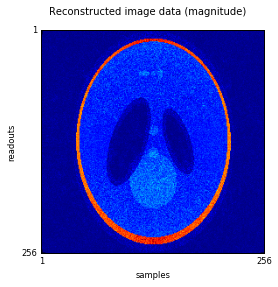

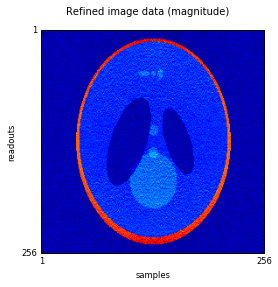

0

In [2]:
#'''
#GRAPPA reconstruction with the steepest descent step: illustrates
#the use of Acquisition Model projections
#
#Usage:
#  grappa_and_steepest_descent.py [--help | options]
#
#Options:
#  -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian_Grappa2.h5]
#  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#  -e <engn>, --engine=<engn>  reconstruction engine [default: Gadgetron]
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF)
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt


try:
    import pylab
    HAVE_PYLAB = True
except:
    HAVE_PYLAB = False

# import engine module
from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian_Grappa2.h5'
data_path = petmr_data_path('mr')



# locate the input data file
input_file = existing_filepath(data_path, data_file)

# acquisition data will be read from an HDF file input_data
acq_data = AcquisitionData(input_file)

# pre-process acquisition data
print('---\n pre-processing acquisition data...')
preprocessed_data = preprocess_acquisition_data(acq_data)

# perform reconstruction
recon = CartesianGRAPPAReconstructor()
recon.set_input(preprocessed_data)
recon.compute_gfactors(False)
print('---\n reconstructing...')
recon.process()
# for undersampled acquisition data GRAPPA computes Gfactor images
# in addition to reconstructed ones
image_data = recon.get_output()

# compute coil sensitivity maps
csms = CoilSensitivityData()
print('---\n sorting acquisition data...')
preprocessed_data.sort()
print('---\n computing sensitivity maps...')
csms.calculate(preprocessed_data)

# create acquisition model based on the acquisition parameters
# stored in preprocessed_data and image parameters stored in
# image_data
acq_model = AcquisitionModel(preprocessed_data, image_data)
acq_model.set_coil_sensitivity_maps(csms)

# use the acquisition model (forward projection) to simulate acquisition data
simulated_data = acq_model.forward(image_data)

# compute the difference between real and simulated acquisition data
preprocessed_data_norm = preprocessed_data.norm()
simulated_data_norm = simulated_data.norm()
residual = simulated_data - preprocessed_data * \
          (simulated_data_norm/preprocessed_data_norm)
rel_residual = residual.norm()/simulated_data_norm
print('---\n reconstruction residual norm (rel): %e' % rel_residual)

# try to improve the reconstruction by the steepest descent step
grad = acq_model.backward(residual)
w = acq_model.forward(grad)
tau = (grad*grad)/(w*w) # locally optimal steepest descent step
refined_image_data = image_data - grad * tau # refined image

image_array = image_data.as_array()
refined_image_array = refined_image_data.as_array()

# show reconstructed and refined images
%matplotlib inline
title = 'Reconstructed image data (magnitude)'
show_3D_array(abs(image_array), suptitle = title, label = 'slice', \
                  xlabel = 'samples', ylabel = 'readouts', show = False)
title = 'Refined image data (magnitude)'
show_3D_array(abs(refined_image_array), suptitle = title, label = 'slice', \
                  xlabel = 'samples', ylabel = 'readouts')
